In [5]:
import ase.units
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from ase.io import read
from numpy.linalg import norm
from ase import units

In [6]:
h = 6.626 * 10 ** -34
eV = 1.60218 * 10 ** -19
pi = np.pi
m = 1.67 * 10 ** -27
angstrom = 10 ** -10
kB = 1.380649 * 10 ** -23
c = 299792458

The data acquired from the NEB calculation results in a graph that shows how the energy changes with respect to the reaction coordinate
<center><img src="fig.png" width=50% /></center>
This is done by simply taking the norm of the difference between coordinates of every atom in each image and the coordinates of every atom in the initial image. So the x-coordinate in the graph is simply the cumulative displacement of each atom in the system

$$\sum_i \langle r_0 - r_i\rangle$$
We also know the energy at each of these coordinates. We are primarily concerned with the Hydrogen atom however, as it's the one that's actually *doing* the tunnelling, so we can calculate its path similarly
$$\sum_i \langle r(H)_0 - r(H)_i\rangle$$
The total displacement for the Hydrogen is ~1Å, which is very close to the total displacement of the entire system of ~1.1Å. One form of approximation could be to simply rescale the x-axis to the displacements of the Hydrogen atom, slightly shrinking the barrier width, whilst keeping the energies of each image constant. Since we only have 7 images, we can use quadratic interpolation between them, this is sensible when the energy is low, and $F=-kx$. The method ASE uses takes into account the force at each point to calculate the slope of the barrier, look at the source code.

Peaker - "In the case of a hydrogen orientating between equivalent carbon sites in examples seen in Chapter 11 a reasonable estimate taken is the difference between the position of the hydrogen in the initial and final structure"

This seems like a poor estimate, as the Hydrogen does not move in a straight line between each structure, the MEP is non-linear.


width = 0.37809405662362455


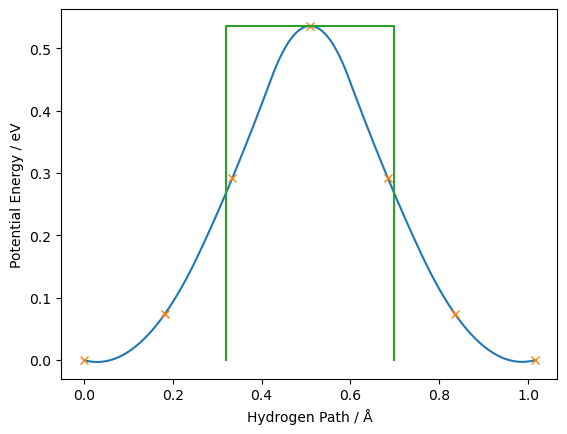

In [7]:
path = [0, 0.1820150229396838, 0.3342538563111191, 0.5092000120736533,
    0.6841350790688399, 0.8355410149952676, 1.015365490771508]
energy =[0, 10181.1545 -10181.0806, 10181.1545 - 10180.8622, 0.536,             
    10181.1545 - 10180.8622, 10181.1545 -10181.0806, 0] 
# energies just taken from CASTEP files
inter = interp1d(path, energy, kind='quadratic')
# using quadratic interpolation, the way ASE does it is by knowing the 
# force and using that to calculate gradient
x = np.linspace(min(path), max(path), 1000)
y = inter(x)
plt.xlabel("Hydrogen Path / Å")
plt.ylabel("Potential Energy / eV")
plt.plot(x, y)
plt.plot(path, energy, 'x')
x = np.array(x)
y = np.array(y)
#print(np.argmin(abs(1 - (y / max(y/2)))))
plt.plot([x[1000-685], x[1000-685], x[687], x[687]], [0, max(y), max(y), 0])
a = -x[1000-687] + x[685]
print(f"width = {a}")

From here we have a choice of two obvious approximations: taking it as a [finite square potential](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Quantum_Mechanics/02._Fundamental_Concepts_of_Quantum_Mechanics/Tunneling), or using the WKB approximation. For the square potential, we will take the FWHM to be the width of our potential barrier (0.378 Å), and the peak to be our height (0.536 eV). The probability, $P$, of the particle tunnelling through the barrier is 
$$P = \exp\Bigg(\frac{-4a\pi}{h}\sqrt{2m(V-E)} \Bigg)$$
For this we need the energy, as we are working at very low temperatures in EPR(4-10K), we will just take the ground state approximation
$$E = \frac{1}{2}h\nu$$
We need the frequency before we can use this, we'll calculate this using data from our phonon calculation.

To estimate our frequency we take the dot product of the Hydrogen's phonon eigenvectors with the direction of the Hydrogen atom's displacement in the first image, this will give us 192 numbers, which we will then multiply by their respective wavenumbers. 
Should normalise the *direction* of the Hydrogen atom's path, but nothing else as it's already normalised.

In [15]:
initial = read("initial.xyz")
displacement = read("displacement.xyz")
int_pos = initial.get_positions()
disp_pos = displacement.get_positions()
dif = int_pos - disp_pos
# ^ require some form of normalisation? Magnitude != 1, surely would cause problems, when
# calculating with more images, you'd get a smaller frequency as the magnitude is smaller

phonon = np.loadtxt('phonon')
phonon = np.delete(phonon, [3,5,7], axis=1)
phonon = np.split(phonon, 192) # split per MODE
phonon[0][0][2] # first MODE, first ATOM, x component
wavenumbers = np.loadtxt('wavenumbers').T[1]

# need to take into account all the atoms that are moving when H is tunnelling

# also need to find the ground state energy, not in the direction of tunnelling
#########################################################################
############################################################################
####### WHAT MIGHT BE REALLY INTERESTING TO DO IS TREAT EACH MODE AS ITS OWN QHO 
####### AND THEN WORK OUT THE ENERGY FROM THERE 
####### n(h, T) = 1/(exp(hnu/kBT)-1)
####### E = hnu*(n(nu, T) + 1/2)
####### BUT DON'T CANCEL OUT THE EQUATIONS, TREAT EACH MODE INDEPENDENTLY
########################################################################
##########################################################################


dif[0] = dif[0] / norm(dif[0]) # this was the key to everything, of *course* it has to be normalised first!
dir_tun_freq = 0
freq = 0
mode = 0
for k in range(192):
    dir_tun_freq -= (np.dot(dif[0], (phonon[k][0][2:]))) * wavenumbers[k]
    mode += (np.dot(dif[0], (phonon[k][0][2:])))
    
print(mode) # doesn't need to sum to 1 as not every mode contributes to it going in that direction, it just can't be MORE than 1
print(dir_tun_freq)

dir_tun_freq *= 100*c
ground_state_energy = 1/2 * h * dir_tun_freq

print(f"frequency in direction of tunnelling = {dir_tun_freq / 1e12} THz")
print(f"ground state energy = {ground_state_energy/eV} eV")
print(f"prob = {np.exp(-4*a*angstrom*pi/h * np.sqrt(2*m*(0.536-ground_state_energy/eV)*eV))}")
print(f"rate = {np.exp(-4*a*angstrom*pi/h * np.sqrt(2*m*(0.536-ground_state_energy/eV)*eV)) * dir_tun_freq * 10**-9} GHz")

-0.930141444106281
1363.3684332142313
frequency in direction of tunnelling = 40.87275737529033 THz
ground state energy = 0.0845169988293056 eV
prob = 1.4437040546864991e-05
rate = 0.5900816554892416 GHz


So we now have our frequency of $\nu = 40.87$ THz, which is a reasonable sounding approximation, and just slightly above the one-phonon mode for diamond (GR1), from here we can say that our ground state energy is 
$$E = \frac{1}{2} h \nu = 0.0845\,\text{eV}$$
$$P = \exp\Bigg(\frac{-4a\pi}{h}\sqrt{2m(V-E)} \Bigg) = 1.444\times10^{-5}$$

We know that the frequency at which our Hydrogen atom vibrates, so to get our rate we simply do
$$k = P\nu = 0.59\,\text{GHz}$$
We only need to be about an order of magnitude lower than the EPR frequency of $30\,\rm{GHz}$ to show an averaged structure, this is in line with what to expect then. 
We have calculated it for the *ground state* energy, which is not quite right, since we are doing this at room temperature, we are obviously above ground state. This just means we *should* expect to see it average at low temperatures, but there is no data on that yet.


<font color='red'>The problem with this might be that E is total *energy* of the ground state, does this need be taken for the tunnelling direction only?</font>

Using the the WKB approximation for our 1D case, the probability of tunnelling can be approximated as 
$$P = \exp\Bigg(\frac{-4\pi}{h}\int_a^b\sqrt{2m(V-E)}\Bigg)$$
where a and b are the points where V and E are equivalent.
As shown below, this gives us a rate of 
$$k = 0.1266\,\rm{GHz}$$
which is also just barely within the range of EPR, however we are still working at ground state *i.e.* low temps.

0.1266731079039398


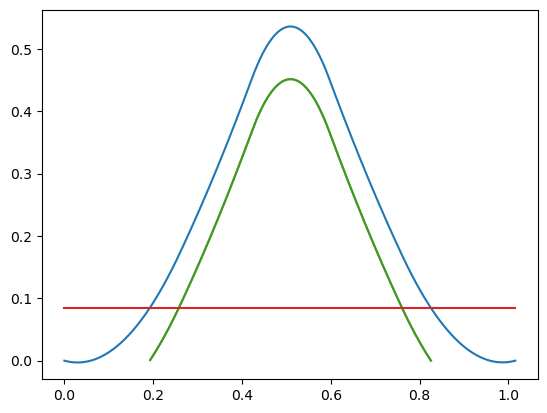

In [9]:
xx = []
yy = []
#ground_state_energy = 99 * 1e12 * h * 0.5 # max C-H bond vibration
for i in range(len(y)):
    if y[i] - ground_state_energy/eV > 0:
        yy.append(y[i] - ground_state_energy/eV)
        xx.append(x[i])

xx = np.array(xx)
yy = np.array(yy)

plt.plot(x, y)
plt.plot(xx, yy)
plt.plot(xx, yy)
plt.plot([x[0], x[-1]], [ground_state_energy/eV]*2)

integral = trapezoid(np.sqrt(2*m*(yy)*eV), xx*angstrom)
print(np.exp(-4 * pi / h * integral) * dir_tun_freq / 1e9)


In [10]:
dynamic = []
with open('dynamical', 'r') as f:
    for line in f.readlines():
        dynamic.append(line.split()[-6:])

dynamic = np.array(dynamic, dtype=np.float64, ndmin=2)
dynamic = np.reshape(dynamic, (64, 3, 192))
D = dynamic[0, 0:, 0]
D

array([14.273308, -8.656432, -8.948177])

In [11]:
print(40 * 1e12 * np.exp(-0.536*eV/(kB*300))) # this is WITHOUT ground state energy

39594.72973534761
